# Good pose classification

Good pose is defined as the pose which is not like Cervical Hypolordosis syndrome.

When you sit down with good pose, your hip is sticked to the chair, and your back shapes S line.

To detect and alert bad pose, I prepared for pictures for good and bad poses.

I trained a simple Convolutional Neural Network (CNN), which classifies binary status whether you are in good pose or not.

### Installation of OpenCV

In [1]:
!pip install opencv-python

You are using pip version 18.0, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Data preparation

I collected good and bad (ill) pose with taking 10 min videos for each class. 

From videos, I extracted frames as jpeg images.

Folder 0 includes good pose frames.

Folder 1 includes bad pose frames.

In [2]:
import os
import cv2
def save_frames(video_path, out_path, class_name):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success:
        img_name = class_name+"_%d.jpg" % count
        img_path = os.path.join(out_path, img_name)
        cv2.imwrite(img_path, image)  
        success,image = vidcap.read()
        print('Read a new frame: ', success)
        count += 1

In [ ]:
save_frames('./Data/right_pose2.mp4','./Data/0/','right2')
save_frames('./Data/ill_pose2.mp4','./Data/1/','ill2')

('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new frame: ', True)
('Read a new f

### Load Dataset

In [1]:
from glob import glob 
import os
import pandas as pd
import cv2
import numpy as np

# Now we define the dimensions of our images.

img_width, img_height = 224, 224

files = sorted(glob('./Data/0/*.jpg'))
labels0 = [ 0 for i in range(len(files))]
images0 = np.empty((len(files), img_width, img_height))

for i, _file in enumerate(files):
    images0[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))

files = sorted(glob('./Data/1/*.jpg'))
labels1 = [ 1 for i in range(len(files))]
images1 = np.empty((len(files), img_width, img_height))

for i, _file in enumerate(files):
    images1[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))
    
images = np.concatenate([images0, images1], axis=0)
labels = labels0 + labels1
print('\033[1m' + 'Ready for next step!')

Ready for next step!


### Dataset visualization

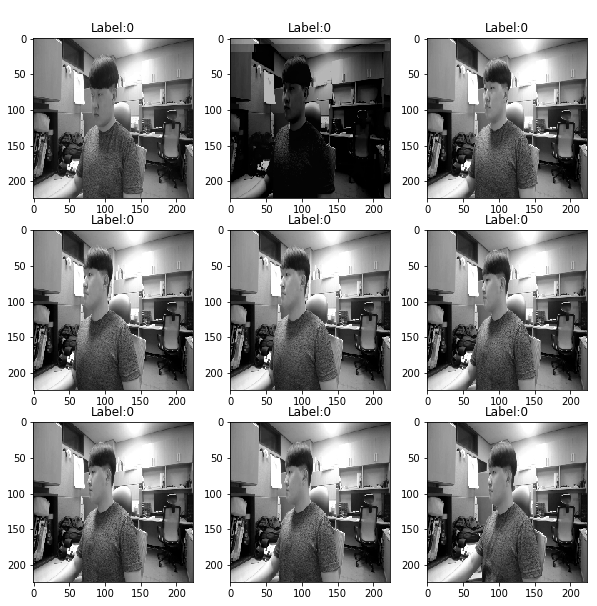

In [3]:
#Let's take a look at the images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title("\nLabel:{}".format(labels[i]))
# show the plot
plt.show()

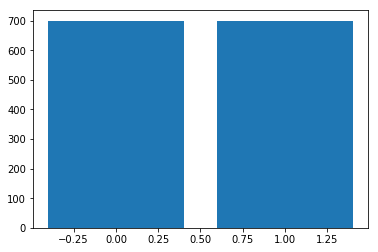

In [4]:
#Let's take a look at the proportion of normal and hemorrhage labels
dum = plt.bar(labels, 700)

### Splitting dataset into train, validation and test set.

In [5]:
#Now we split the dataset into train (80%), validation (10%) and test (10%) sets.
from sklearn.model_selection import train_test_split
import numpy as np

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=1)

print((len(train_images), len(val_images), len(test_images)))

/home/jungrae/anaconda2/envs/tf_cu90/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/jungrae/anaconda2/envs/tf_cu90/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/home/jungrae/anaconda2/envs/tf_cu90/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/home/jungrae/anaconda2/envs/tf_cu90/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/hom

(2575, 322, 322)


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, Input
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications import ResNet50

In [ ]:
K.clear_session()

input_shape = (img_width, img_height, 1)
img_input = Input(shape=input_shape)
img_conc = Concatenate()([img_input, img_input, img_input])    

baseline = ResNet50(input_tensor=img_conc,weights='imagenet',include_top=False)
x = GlobalAveragePooling2D()(baseline.output)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=baseline.input, outputs=x)

for layer in baseline.layers:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()
print ('\033[1m' + 'Ready for next step!')

### CNN configuration

In [ ]:
K.clear_session()

input_shape = (img_width, img_height, 1)

model = None

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print ('\033[1m' + 'Ready for next step!')

### Set data generator

In [ ]:
from numpy.random import seed
seed(1337)
from tensorflow import set_random_seed
set_random_seed(1337)

import warnings
warnings.filterwarnings('ignore')

nb_train_samples = len(train_images)
nb_validation_samples = len(val_images)
epochs = 100
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(
    train_images[..., np.newaxis],
    train_labels,
    batch_size=batch_size)

validation_generator = val_datagen.flow(
    val_images[..., np.newaxis],
    val_labels,
    batch_size=batch_size)

print ('\033[1m' + 'Ready for next step!')

### Training CNN

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

### Loss visualization

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluation of CNN

In [ ]:
print("Accuracy: " + str(model.evaluate(test_images[..., np.newaxis] / 255., test_labels)[1] * 100) + "%")

### Save CNN

In [ ]:
model.save('./pose_classifier_v2.hdf5')

### Load the saved model

In [ ]:
from keras.models import load_model
import keras.backend as K

K.clear_session()
model = load_model('./pose_classifier.hdf5')

### Test visualization

In [ ]:
preds = model.predict(test_images[..., np.newaxis] / 255.)

In [ ]:
print(test_labels)
print(map(int, preds > 0.5))

In [ ]:
import subprocess as s
import os
idx = 0
while True: 
    idx = int(input("Press 0 to 164(Quit : 999) : \n"))
    if idx == 999:
        print("End of program")
        break
    plt.imshow(test_images[idx], cmap='gray')
    plt.title('Good pose : 0, ill pose : 1'+'\nPrediction : %d'%preds[idx]+", Ground truth : %d"%test_labels[idx])
    plt.show()
    if preds[idx] == 1:
        s.call(['notify-send','-i','weather-storm','Pose Alert','Please, stretch your body.','-h','string:x-canonical-private-synchronous:anything'])
        duration = 0.5  # seconds
        freq = 550  # Hz
        os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

### Real-time pose classification

In [ ]:
import numpy as np
import cv2
import subprocess as s
import os
from keras.preprocessing.image import ImageDataGenerator

cap = cv2.VideoCapture(0)
img_width = 224
img_height = 224

from keras.models import load_model
model = load_model('./pose_classifier_v2.hdf5')

while(True):
    try:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        input_image = cv2.resize(gray, (img_width, img_height))
        prediction = model.predict(input_image.reshape(1,input_image.shape[0],input_image.shape[1],1) / 255.)
        prediction = int(prediction > 0.5)
        
        location = (20, 200)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        thickness = 2
        
        if prediction == 0:
            pred_text = "Good pose"
            font_color = (0,0,255)
        else:
            pred_text = "Bad pose"
            font_color = (255,0,0)
        print(pred_text)
        
        # Display the resulting frame
        frame = cv2.resize(frame, (img_width, img_height))
        cv2.putText(frame, pred_text, location, font, fontScale, font_color, thickness)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        if prediction == 1:
            s.call(['notify-send','-i','weather-storm','Pose Alert','Please, stretch your body.','-h','string:x-canonical-private-synchronous:anything'])
            duration = 0.5  # seconds
            freq = 550  # Hz
            # os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    except  Exception as ex:
        print('Error occured : ', ex)
        break

cap.release()
cv2.destroyAllWindows()

Using TensorFlow backend.


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Good

Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
G

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
G

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pos

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
G

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Go

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good p

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pos

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Go

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad 

Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good po

Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose

Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pos

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad p

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Goo

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad p

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Ba

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
G

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad p

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Ba

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad 

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad p

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good 

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad 

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Go

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good p

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Ba

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good p

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad 

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pos

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Go

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad p

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad po

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
B

Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good po

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Ba

Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose


Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Good pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad pose
Bad

# Reference
1. [Head CT Hemorrhage Kernel](https://www.kaggle.com/felipekitamura/head-ct-hemorrhage-kernel) : Basic pipline of data preprocessing, model configuration, training, and test
2. [How do I send desktop notifications using Python 3?](https://askubuntu.com/questions/616985/how-do-i-send-desktop-notifications-using-python-3)
3. [How to send desktop notifications in Linux.](https://terrameijar.wordpress.com/2017/06/05/how-to-send-desktop-notifications-in-linux/)
4. [How do I use 'notify-send' to immediately replace an existing notification?
](https://askubuntu.com/questions/161851/how-do-i-use-notify-send-to-immediately-replace-an-existing-notification)
5. [Sound alarm when code finishes](https://stackoverflow.com/questions/16573051/sound-alarm-when-code-finishes)
6. [Getting Started with Videos](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html)
7. [파이썬 파트12. 예외처리](https://wayhome25.github.io/python/2017/02/26/py-12-exception/)
8. [OpenCV 강좌 C++ & Python - 글자(문자열) 출력하는 putText 함수 사용방법](https://webnautes.tistory.com/1212)
9. [Python - Extracting and Saving Video Frames](https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames)